# Intro

## Load and import CapsNet

First, let's clone our GitHub repo and import all parts which will be used in this notebook.

In [0]:
!pip install --no-cache-dir --upgrade git+https://github.com/tumido/face_biometrics_descriptor-code.git

from sklearn.datasets import fetch_lfw_people
from capsnet import preprocess_lfw_people, CapsNet

  Cloning https://github.com/tumido/face_biometrics_descriptor-code.git to /tmp/pip-req-build-ewrmfbl2
  Found existing installation: capsnet 0.2.6
    Uninstalling capsnet-0.2.6:
      Successfully uninstalled capsnet-0.2.6
  Running setup.py install for capsnet ... done


Using TensorFlow backend.


## Auxilary imports

Additional imports used in this Notebook would help to visualize data.

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

Install and start a TensorBoard in Colab

In [0]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc = TensorBoardColab()
tensor_board_callback = TensorBoardColabCallback(tbc, batch_size=10) #, histogram_freq=5, write_graph=True, write_grads=True, write_images=True)

Wait for 8 seconds...
TensorBoard link:
https://8f283382.ngrok.io


## Verify GPU

in the next cell we verify that a GPU is available to our use. The output should contain a GPU details.

In [0]:
from tensorflow.test import is_gpu_available
from tensorflow.python.client import device_lib

if not is_gpu_available():
    raise SystemError('GPU device not found')

desc = [f'path: {d.name}, {d.physical_device_desc}' for d in device_lib.list_local_devices() if d.device_type == "GPU"][0]
print("\n".join(desc.split(", ")))

path: /device:GPU:0
device: 0
name: Tesla T4
pci bus id: 0000:00:04.0
compute capability: 7.5


## Collect data set 

We're gonna be working with LFW dataset

In [0]:
people = fetch_lfw_people(
    color=True,
    min_faces_per_person=25
)


data = preprocess_lfw_people(people)
(x_train, y_train), (x_test, y_test) = data

In [0]:
metrics = [
    ["Identities", len(np.unique(people.target, axis=0))],
    ["Total images", people.target.shape[0]],
    ["Train images", len(y_train)],
    ["Test images", len(y_test)],
    ["Image shape", x_train.shape[1:]]
]
pd.DataFrame(metrics, columns=["Name", "Value"])

,Name,Value
0,Identities,42
1,Total images,2588
2,Train images,2070
3,Test images,518
4,Image shape,"(32, 32, 3)"


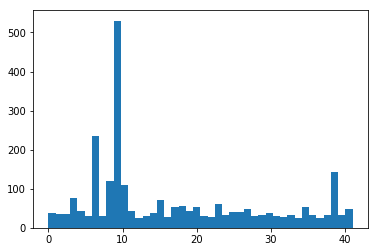

In [0]:
_ = plt.hist(people.target, bins=people.target_names.shape[0])

6: Colin Powell


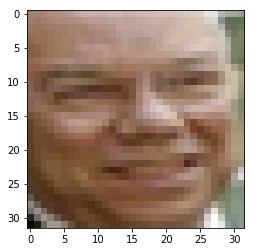

In [0]:
i = randint(0, len(x_train))
plt.imshow(x_train[i])
print("{}: {}".format(np.argmax(y_train[i]), people.target_names[np.argmax(y_train[i])]))

## CapsNet

Let's begin training our network

In [0]:
capsnet = CapsNet(
    x_train.shape[1:],
    len(np.unique(y_train, axis=0))
)
capsnet.models['train'].summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv2d (Conv2D)         (None, 24, 24, 256)  62464       input_image[0][0]                
__________________________________________________________________________________________________
encoder_dropout (Dropout)       (None, 24, 24, 256)  0           encoder_conv2d[0][0]             
_______________________________________________

In [10]:
history = capsnet.train(data, batch_size=10, extra_callbacks=[tensor_board_callback])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
207/207 [==============================] - 102s 495ms/step - loss: 0.7929 - capsnet_loss: 0.7928 - decoder_loss: 0.2207 - capsnet_acc: 0.1063 - val_loss: 0.8099 - val_capsnet_loss: 0.8099 - val_decoder_loss: 0.0779 - val_capsnet_acc: 0.0154

Epoch 00001: val_capsnet_acc improved from -inf to 0.01544, saving model to model/weights.01.h5
Epoch 2/100
207/207 [==============================] - 99s 480ms/step - loss: 0.7747 - capsnet_loss: 0.7747 - decoder_loss: 0.0456 - capsnet_acc: 0.1773 - val_loss: 0.7960 - val_capsnet_loss: 0.7960 - val_decoder_loss: 0.0383 - val_capsnet_acc: 0.2220

Epoch 00002: val_capsnet_acc improved from 0.01544 to 0.22201, saving model to model/weights.02.h5
Epoch 3/100
207/207 [==============================] - 99s 479ms/step - loss: 0.7591 - capsnet_loss: 0.7591 - decoder_loss: 0.0364 - capsnet_acc: 0.1792 - val_loss: 0.7735 

## Results of training

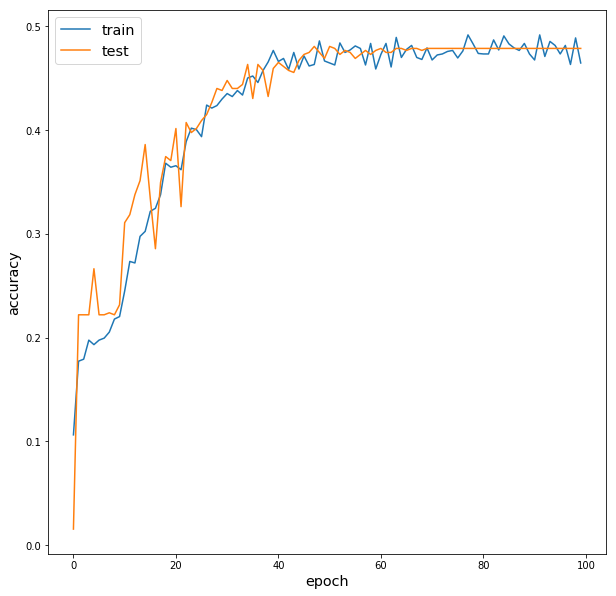

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['capsnet_acc'])
plt.plot(history.history['val_capsnet_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')